In [1]:
# keras系
from keras import models
from keras import layers
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense,Merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, Deconvolution2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
from keras.utils.visualize_util import plot
from keras.datasets import cifar100

# その他
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cPickle
import random
import sys
from tqdm import tqdm

Using TensorFlow backend.
/Users/YumaKajihara/.pyenv/versions/anaconda2-2.5.0/lib/python2.7/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory
  stacklevel=stacklevel + 1):


In [2]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [11]:
def create_generator(latent_size):
    latent_input = Input(shape=[latent_size])
    perception_input = Input(shape=[12])
    PH = Dense(800, init='glorot_normal')(perception_input)
    H = merge([latent_input, PH], mode='concat', concat_axis=1)
    H = BatchNormalization(mode=2)(H)
    H = Reshape( [5, 5, 40] )(H)
    H = Convolution2D(1024, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = Activation('relu')(H)
    H = UpSampling2D(size=(2, 2))(H)
    H = Convolution2D(512, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = Activation('relu')(H)
    H = UpSampling2D(size=(2, 2))(H)
    H = Convolution2D(256, 5, 5, border_mode='same', init='glorot_uniform')(H)
    H = Activation('relu')(H)
    H = UpSampling2D(size=(2, 2))(H)
    H = Convolution2D(128, 5, 5, border_mode='same', init='glorot_uniform')(H)
    H = Activation('relu')(H)
    H = UpSampling2D(size=(2, 2))(H)
    H = Convolution2D(64, 5, 5, border_mode='same', init='glorot_uniform')(H)
    H = Activation('relu')(H)
    H = UpSampling2D(size=(2, 2))(H)
    H = Convolution2D(32, 5, 5, border_mode='same', init='glorot_uniform')(H)
    H = Activation('relu')(H)
    H = UpSampling2D(size=(2, 2))(H)
    H = Convolution2D(1, 5, 5, border_mode='same', init='glorot_uniform')(H)
    g_V = Activation('sigmoid')(H)
    generator_model = Model([latent_input, perception_input], g_V)
    return generator_model

In [4]:
def create_discriminator(img_shape):
    image_input = Input(shape=img_shape)
    perception_input = Input(shape=[12])
    H = Convolution2D(32, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(image_input)
    H = LeakyReLU(0.2)(H)
    H = Convolution2D(64, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(0.2)(H)
    H = Convolution2D(128, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(0.2)(H)
    H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(0.2)(H)
    H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(0.2)(H)
    H = Convolution2D(1024, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(0.2)(H)
    H = Convolution2D(1024, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = Flatten()(H)
    H = Dense(100)(H)
    H = LeakyReLU(0.2)(H)
    H = Dropout(0.5)(H)
    PH = Dense(100, init='glorot_normal')(perception_input)
    H = merge([H, PH], mode='sum')
    d_V = Dense(2,activation='softmax')(H)
    discriminator_model = Model([image_input, perception_input], d_V)
    return discriminator_model

In [5]:
# 論文にちゃんと書いてなかったぽん。
def create_perception_model(img_shape):
    image_input = Input(shape=img_shape)
    H = Convolution2D(32, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(image_input)
    H = LeakyReLU(0.2)(H)
    H = Dropout(0.5)(H)
    H = Convolution2D(64, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(0.2)(H)
    H = Dropout(0.5)(H)
    H = Flatten()(H)
    H = Dense(500, init='glorot_normal')(H)
    H = Dense(500, init='glorot_normal')(H)
    H = Dense(12, init='glorot_normal')(H)
    p_V = Activation('sigmoid')(H)
    perception_model = Model(image_input, p_V)
    return perception_model

In [6]:
class PDTG:
    def __init__(self, latent_size, input_shape):
        self.latent_size = latent_size
        self.input_shape = input_shape
        self.is_model_created = False

    def create_model(self):
        self.generator = create_generator(self.latent_size)
        self.discriminator = create_discriminator(self.input_shape)
        self.perception_model = create_perception_model(self.input_shape)
        gan_input = Input(shape=[self.latent_size])
        perception_input = Input(shape=[12])
        H = self.generator([gan_input, perception_input])
        p_V = self.perception_model(H)
        g_V = self.discriminator([H, perception_input])
        self.g_p_model = Model([gan_input, perception_input], p_V)
        self.g_d_model = Model([gan_input, perception_input], g_V)
        self.model = Model([gan_input, perception_input], [g_V, p_V])
        self.g_p_model.summary()
        self.g_d_model.summary()
        plot(self.model, to_file="pdtg.png", show_shapes=True, show_layer_names=True)
        self.is_model_created = True
        
    def compile_model(self):
        self.generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4))
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4))
        self.perception_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4))
        self.g_d_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4))
        self.g_p_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4))

In [82]:
generator = create_generator(200)
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4))
generator.summary()
plot(generator, to_file="sample_generator.png", show_shapes=True, show_layer_names=True)
discriminator = create_discriminator((320, 320, 1))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4))
discriminator.summary()
plot(discriminator, to_file="sample_discriminator.png", show_shapes=True, show_layer_names=True)
perception_model = create_perception_model((320, 320, 1))
perception_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4))
perception_model.summary()
plot(perception_model, to_file="sample_perception_model.png", show_shapes=True, show_layer_names=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_83 (InputLayer)            (None, 12)            0                                            
____________________________________________________________________________________________________
input_82 (InputLayer)            (None, 200)           0                                            
____________________________________________________________________________________________________
dense_90 (Dense)                 (None, 800)           10400       input_83[0][0]                   
____________________________________________________________________________________________________
merge_27 (Merge)                 (None, 1000)          0           input_82[0][0]                   
                                                                   dense_90[0][0]          

In [61]:
pdtg = PDTG(200, (320, 320, 1))
pdtg.create_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_20 (InputLayer)            (None, 200)           0                                            
____________________________________________________________________________________________________
input_21 (InputLayer)            (None, 12)            0                                            
____________________________________________________________________________________________________
model_10 (Model)                 (None, 299, 299, 1)   243124033   input_20[0][0]                   
                                                                   input_21[0][0]                   
____________________________________________________________________________________________________
model_12 (Model)                 (None, 12)            180309108   model_10[1][0]          

## 訓練データ生成

In [7]:
params = [
    "contrast", 
    "repetitive",
    "granular",
    "random",
    "rough",
    "feature density",
    "direction",
    "structural complexity",
    "coarse",
    "regular",
    "oriented",
    "uniform"
]
df = pd.read_csv('texture_database/rating.csv')

max_val = 0.0
min_val = 5.0
for param in params:
    for val in df[param]:
        if max_val < val:
            max_val = val
        if min_val > val:
            min_val = val
print "max : %f, min %f" % (max_val, min_val)
range_num = max_val - min_val
for param in params:
    index = 0
    for val in df[param]:
        df[param][index] = (val - min_val) / range_num
        index = index + 1
#     print df[param]

# 画像を変換
images = []
for i in range(450):
    index = i + 1
    img_path = "./texture_database/textures/" + str(index) + ".png"
    img = load_img(img_path, target_size=(320,320), grayscale=True)
    arr = np.asarray(img)
    arr = arr.tolist()
    image = []
    image.append(arr)
    images.append(image)
images = np.array(images)
print images.shape

max : 8.850000, min 1.000000
(450, 1, 320, 320)


In [8]:
images = images.reshape([450, 320, 320,1])
X_train, X_test = np.vsplit(images, [400])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print np.min(X_train), np.max(X_train)
print('X_train shape:', X_train.shape)
print('Image Shape:', X_train.shape[1:])
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 0.937255
('X_train shape:', (400, 320, 320, 1))
('Image Shape:', (320, 320, 1))
(400, 'train samples')
(50, 'test samples')


### 学習

In [9]:
def plot_loss(losses):
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g_d"], label='generative-discriminitive loss')
        plt.plot(losses["g_p"], label='generative-perspective loss')
        plt.plot(losses["p"], label='perspective loss')
        plt.legend()
        plt.show()

In [ ]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [29]:
def train(pdtg, batch_size, nb_epoch):
    losses = {"d":[], "g_d":[], "g_p":[], "p":[]}
    index = 1
    for e in tqdm(range(nb_epoch)):
        print "--------------%d回目のTraining--------------" % index
        #batchの作成
        indecies = np.random.randint(0,X_train.shape[0],size=batch_size)
        image_batch = X_train[indecies,:,:,:]
        perception_features = df.iloc[indecies].values
        noise_gen = np.random.uniform(0,1,size=[batch_size,200])
        noise_gen_per = np.random.uniform(0,1,size=[batch_size,12])
        generated_images = pdtg.generator.predict([noise_gen, noise_gen_per])
        
        #ジェネった画像でdiscriminatorの学習
        X = np.concatenate((image_batch, generated_images))
        X_2 = np.concatenate((perception_features, noise_gen_per))
        y = np.zeros([2*batch_size,2])
        y[0:batch_size,1] = 1
        y[batch_size:,0] = 1
        d_loss  = pdtg.discriminator.train_on_batch([X, X_2],y)
        losses["d"].append(d_loss)
        print "Training Discriminator :::: value : %f" % d_loss
        
        #ジェネった画像でperception_modelの学習
        p_loss = pdtg.perception_model.train_on_batch(X, X_2)
        losses["p"].append(p_loss)
        print "Training Perception Model :::: value : %f" % p_loss
        
        noise_tr = np.random.uniform(0,1,size=[batch_size,200])
        noise_tr_per = np.random.uniform(0,1,size=[batch_size,12])
        y2 = np.zeros([batch_size,2])
        y2[:,1] = 1
        
        g_d_loss = pdtg.g_d_model.train_on_batch([noise_tr, noise_tr_per],y2)
        losses["g_d"].append(g_d_loss)
        print "Training Generative Model(Dis) :::: value : %f" % g_d_loss
        g_p_loss = pdtg.g_p_model.train_on_batch([noise_tr, noise_tr_per],noise_gen_per)
        losses["g_p"].append(g_p_loss)
        print "Training Generative Model(Per) :::: value : %f" % g_p_loss
        print "\n\n\n"
        index = index + 1
        # Updates plots
        if e%25==24:
            plot_loss(losses)

In [30]:
pdtg = PDTG(200, (320, 320, 1))
pdtg.create_model()
pdtg.compile_model()
train(pdtg, 100, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 200)           0                                            
____________________________________________________________________________________________________
input_14 (InputLayer)            (None, 12)            0                                            
____________________________________________________________________________________________________
model_7 (Model)                  (None, 320, 320, 1)   9456449     input_13[0][0]                   
                                                                   input_14[0][0]                   
____________________________________________________________________________________________________
model_9 (Model)                  (None, 12)            205109108   model_7[1][0]           

  0%|          | 1/5000 [06:52<572:07:58, 412.02s/it]






--------------2回目のTraining--------------
Training Discriminator :::: value : 0.706487
Training Perception Model :::: value : 14.550874
Training Generative Model(Dis) :::: value : 0.918887
Training Generative Model(Per) :::: value : 15.240427

  0%|          | 2/5000 [13:38<569:39:45, 410.32s/it]






--------------3回目のTraining--------------
Training Discriminator :::: value : 0.773417
Training Perception Model :::: value : 14.469790
Training Generative Model(Dis) :::: value : 0.857741
Training Generative Model(Per) :::: value : 14.896322

  0%|          | 3/5000 [20:42<575:12:00, 414.39s/it]






--------------4回目のTraining--------------
Training Discriminator :::: value : 0.879997
Training Perception Model :::: value : 14.239109
Training Generative Model(Dis) :::: value : 0.790130


KeyboardInterrupt: 

In [54]:
indecies = np.random.randint(0,X_train.shape[0],size=50)
print indecies[:]
print df.iloc[indecies].values

[ 78 167 351  46 210 294 187 144 261 189 253 200 378  53 292 388 214 241
  26  62 328 389 395 358 383 363 117  36 122 137 321  27 222 315 289  17
 366 284 216 350 249 373 279   2 385 171 305 387 351 188]
[[ 0.23566879  0.2611465   0.14649682  0.64968153  0.71974522  0.22929936
   0.14649682  0.39490446  0.39490446  0.1910828   0.19745223  0.43949045]
 [ 0.42675159  0.33757962  0.59235669  0.70700637  0.33757962  0.66878981
   0.14012739  0.57324841  0.56050955  0.20382166  0.22929936  0.42038217]
 [ 0.59872611  0.57324841  0.59872611  0.70700637  0.36305732  0.67515924
   0.14012739  0.42675159  0.54140127  0.33757962  0.14012739  0.52866242]
 [ 0.60509554  0.43949045  0.12738854  0.29936306  0.47770701  0.52229299
   0.6433121   0.30573248  0.55414013  0.55414013  0.73248408  0.54140127]
 [ 0.38853503  0.55414013  0.21019108  0.4522293   0.47770701  0.55414013
   0.61783439  0.40127389  0.47770701  0.47770701  0.64968153  0.57324841]
 [ 0.33121019  0.84076433  0.42038217  0.12738854  

[[ 194.559021    238.78100586  248.5484314  ...,  251.09054565
   251.63656616  247.06210327]
 [ 212.44882202  247.35804749  252.36068726 ...,  253.94845581
   254.06835938  250.87826538]
 [ 219.26409912  250.3190918   253.2636261  ...,  254.83325195  254.6421051
   253.02301025]
 ..., 
 [ 218.31077576  248.01771545  253.45854187 ...,  254.76313782
   253.15301514  245.45335388]
 [ 199.34205627  244.22477722  250.26499939 ...,  254.00105286
   250.89266968  234.63116455]
 [ 162.9980011   229.35295105  243.37794495 ...,  246.41772461
   236.84553528  186.67555237]]
[[ 192.33441162  237.16270447  247.70097351 ...,  250.30117798
   250.93928528  245.73216248]
 [ 210.33441162  246.42851257  251.92628479 ...,  253.65390015  253.7979126
   250.00810242]
 [ 217.28308105  249.65898132  252.97187805 ...,  254.76248169
   254.51191711  252.51777649]
 ..., 
 [ 218.13050842  247.89883423  253.40539551 ...,  254.7375946   253.01257324
   245.0057373 ]
 [ 199.27922058  244.04104614  250.13479614 ...

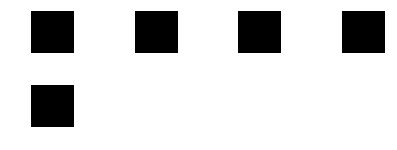

In [28]:
noise_gen = np.random.uniform(0,1,size=[5,200])
noise_gen_per = np.random.uniform(0,1,size=[5,12])
image = pdtg.generator.predict([noise_gen, noise_gen_per])
image *= 255.

import matplotlib.pyplot as plt
%matplotlib inline
n_ex=16
dim=(4,4)
figsize=(10,10)
for i in range(image.shape[0]):
    plt.subplot(dim[0],dim[1],i+1)
    img = image[i,:,:,0]
    print image[i,:,:,0]
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()